In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split, TensorDataset
import seaborn as sns

import datetime
import os

import optuna
import torch.optim as optim

import json

In [4]:
# build the gradient boosting regression model with PyTorch
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_rate):
        super(Net, self).__init__()
        self.dropout = nn.Dropout(p=dropout_rate)
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3= nn.Linear(hidden_size, hidden_size)
        self.fc4= nn.Linear(hidden_size, hidden_size)
        self.fc5= nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.dropout(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.dropout(out)
        out = self.relu(out)
        out = self.fc3(out)
        out = self.dropout(out)
        out = self.relu(out)
        out = self.fc4(out)
        out = self.dropout(out)
        out = self.relu(out)
        out = self.fc5(out)
        return out
    
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()
        
    def forward(self, outputs, labels):
        # Define your custom loss function here
        # This is a simple example, replace it with your own function
        custom_loss = 3*(torch.abs(labels - outputs))*(torch.abs(labels - 1/3) + torch.abs(labels -2/3))
        return custom_loss
    
    
def save_loss_in_csv(model_num, loss):
    df = pd.read_csv('loss.csv')
    # add all val to the end of df
    df[model_num] = loss
    df.to_csv('loss.csv')

def get_one_hot_weekday(date_str):
    # Convert the date string to a datetime object
    date = datetime.datetime.strptime(date_str, '%Y%m%d')
    
    # Get the weekday (Monday is 0, Sunday is 6)
    weekday = date.weekday()
    
    # Create a one-hot encoded list for the weekday
    one_hot_weekday = [1 if i == weekday else 0 for i in range(7)]
    
    return one_hot_weekday

def time_to_minute(time_str):
    hours, minutes = map(int, time_str.split(':'))
    total_minutes = hours * 60 + minutes
    return total_minutes

    
def objective(trial):
    # Sample hyperparameters
    input_size = 8
    hidden_size = trial.suggest_int('hidden_size', 3, 1000, log=True)  # Single hidden size for all layers
    output_size = 1
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.3)

    # Instantiate the model with sampled hyperparameters
    model = Net(input_size, hidden_size, output_size, dropout_rate)

    # Define the loss function and optimizer
    criterion = CustomLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop
    for epoch in range(100):
        training_loss = 0.0
        eval_loss = 0.0

        # Iterate over the DataLoader for training data
        for i, data in enumerate(train_loader):
            inputs, labels = data
            inputs = inputs.float()
            labels = labels.float()
            optimizer.zero_grad()
            outputs = model(inputs)
            outputs = outputs.reshape(-1)
            loss = criterion(outputs, labels).sum()
            loss.backward()
            optimizer.step()
            training_loss += loss.item()

        model.eval()
        outloss = 0
        # Iterate over the DataLoader for test data
        with torch.no_grad():
            for i, data in enumerate(test_loader):
                inputs, labels = data
                inputs = inputs.float()
                labels = labels.float()
                outputs = model(inputs).reshape(-1)
                loss = criterion(outputs, labels).sum()
                eval_loss += loss

        # Optuna logs the running loss for each epoch
        trial.report(eval_loss, epoch)

        # Handle pruning based on the intermediate value
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    # Return the running loss as the objective value to minimize
    return eval_loss


class station_model():
    def __init__(self, station):
        self.station = station

    def get_data_loader(self):
        df = pd.read_parquet(f'parquets/{self.station}.parquet')
        TOT = df['tot'].iloc[0]
        df['sbi'] = df['sbi']/TOT
        df['time'] = df['time']/1440

        # x is dataset without 'sbi', y is 'sbi'
        X = df.drop(['tot', 'sbi','bemp' ,'act', 'tot', 'station'], axis=1)
        y = df['sbi']

        X = X.to_numpy()
        y = y.to_numpy()

        X = torch.from_numpy(X)
        y = torch.from_numpy(y)
        dataset = TensorDataset(X, y)

        # get train, test loader
        self.all_data_loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)

        # split train, test
        train_size = int(0.8 * len(dataset))
        test_size = len(dataset) - train_size
        train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

        # get train, test loader
        self.train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
        self.test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=True)
        print(f'get data loader for {self.station}')

    def objective(self,trial):
        # Sample hyperparameters
        input_size = 8
        hidden_size = trial.suggest_int('hidden_size', 3, 2000, log=True)  # Single hidden size for all layers
        output_size = 1
        learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)
        dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.5)

        # Instantiate the model with sampled hyperparameters
        model = Net(input_size, hidden_size, output_size, dropout_rate)

        # Define the loss function and optimizer
        criterion = CustomLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        # Training loop
        for epoch in range(60):
            training_loss = 0.0
            eval_loss = 0.0
            # Iterate over the DataLoader for training data
            for i, data in enumerate(self.train_loader):
                inputs, labels = data
                inputs = inputs.float()
                labels = labels.float()
                optimizer.zero_grad()
                outputs = model(inputs)
                outputs = outputs.reshape(-1)
                loss = criterion(outputs, labels).sum()
                loss.backward()
                optimizer.step()
                training_loss += loss.item()

            model.eval()
            # Iterate over the DataLoader for test data
            with torch.no_grad():
                for i, data in enumerate(self.test_loader):
                    inputs, labels = data
                    inputs = inputs.float()
                    labels = labels.float()
                    outputs = model(inputs).reshape(-1)
                    loss = criterion(outputs, labels).sum()
                    eval_loss += loss

            # Optuna logs the running loss for each epoch
            trial.report(eval_loss, epoch)
            # Handle pruning based on the intermediate value
            if trial.should_prune():
                raise optuna.exceptions.TrialPruned()
        # Return the running loss as the objective value to minimize
        return eval_loss      


    def get_best_param(self):
        # Create an Optuna Study
        study = optuna.create_study(direction='minimize', storage='sqlite:///db.sqlite3', study_name=f'{self.station}', load_if_exists=True)
        num_trials = len(study.trials)

        if num_trials <= 10:
            study.optimize(self.objective, n_trials=5)
        # Run the optimization process

        print(f'{self.station} eval_loss: {study.best_trial.value}')

        # Access the best hyperparameters
        best_params = study.best_trial.params

        self.best_params = best_params

        print(self.station,' Best hyperparameters:', best_params)

    def train(self):
        # Instantiate the final model with the best hyperparameters
        final_model = Net(8, self.best_params['hidden_size'], 1, self.best_params['dropout_rate'])

        # ... rest of your training code for the final model
        criterion = CustomLoss()
        optimizer = optim.Adam(final_model.parameters(), lr=self.best_params['learning_rate'])

        # train with whole dataset
        running_loss = 0.0
        loss_list = []
        for epoch in range(10):
            for i, data in enumerate(self.all_data_loader):
                inputs, labels = data
                inputs = inputs.float()
                labels = labels.float()
                optimizer.zero_grad()
                outputs = final_model(inputs)
                outputs = outputs.squeeze()
                loss = criterion(outputs, labels).sum()
                loss.backward()
                optimizer.step()
                running_loss += loss.item()/128
            print(f'epoch: {epoch+1}, loss: {running_loss/self.all_data_loader.__len__()}')
            loss_list.append(running_loss/self.all_data_loader.__len__())
            running_loss = 0.0
        save_loss_in_csv(self.station, loss_list)
        
        final_model.eval()
        # save model
        torch.save(final_model, f'models/{self.station}')

In [5]:
# create submission data

df = pd.read_csv('html.2023.final.data/sample_submission.csv')
# ['time', 'mon', 'tue', 'wed', 'thu', 'fri', 'sat', 'sun']
submission = pd.DataFrame(columns=['id','time', 'mon', 'tue', 'wed', 'thu', 'fri', 'sat', 'sun'])
rows = []
for x in df['id']:
    date = x[:8]
    station = x[9:18]
    time = x[19:]
    one_hot_weekday = get_one_hot_weekday(date)
    time = time_to_minute(time)/1440
    row = {'id': x,'time':time, 'mon':one_hot_weekday[0], 'tue':one_hot_weekday[1], 'wed':one_hot_weekday[2], 'thu':one_hot_weekday[3], 'fri':one_hot_weekday[4], 'sat':one_hot_weekday[5], 'sun':one_hot_weekday[6]}
    rows.append(row)

submission = pd.DataFrame(rows)

# create submission loader


In [6]:
# import torch

# folder_path = 'models/'  # replace with your actual folder path
# trained_models = os.listdir(folder_path)
# trained_models.sort()
# print(trained_models)


# outputdf = pd.DataFrame(columns=['id','sbi'])
# tmp = []

# ## read models
# for models in trained_models:
#     # read json
#     find_tot = pd.read_json(f'html.2023.final.data/release/20231002/{models}.json', convert_axes=False)
#     find_tot = find_tot.transpose()
#     for n in find_tot['tot'].to_numpy():
#         try:
#             m = int(n)
#             TOT = n
#             break
#         except:
#             continue

#     model = torch.load(folder_path + models)
#     model.eval()
#     tmp = []

#     for row in submission.iterrows():
#         data = row[1]
#         if data['id'][9:18] == models:
#             inputs = torch.tensor(data[1:].tolist()).float()
#             outputs = model(inputs)
#             outputs = outputs.item()
#             row = {'id':data.iloc[0], 'sbi':(outputs*TOT)}
#             tmp.append(row)
#     # save without index
#     outputdf = pd.DataFrame(tmp)
#     outputdf.to_csv(f'predict/{models}.csv', index=False)
#     print(f'save {models}.csv')
#     print(outputdf.shape)


    

In [7]:
import torch

class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()
        
    def forward(self, outputs, labels):
        # Define your custom loss function here
        # This is a simple example, replace it with your own function
        custom_loss = 3*(torch.abs(labels - outputs))*(torch.abs(labels - 1/3) + torch.abs(labels -2/3))
        return custom_loss
    
folder_path = 'models/'  # replace with your actual folder path
trained_models = os.listdir(folder_path)
trained_models.sort()
print(trained_models)

Ein = {}
## read models
for models in trained_models:
    # read json
    find_tot = pd.read_json(f'html.2023.final.data/release/20231002/{models}.json', convert_axes=False)
    find_tot = find_tot.transpose()
    for n in find_tot['tot'].to_numpy():
        try:
            m = int(n)
            TOT = n
            break
        except:
            continue

    model = torch.load(folder_path + models)
    model.eval()
    tmp = []

    df = pd.read_parquet(f'parquets/{models}train.parquet')
    TOT = df['tot'].iloc[0]
    df['sbi'] = df['sbi']/TOT
    df['time'] = df['time']/1440

    # x is dataset without 'sbi', y is 'sbi'
    X = df.drop(['tot', 'sbi','bemp' ,'act', 'tot', 'station'], axis=1)
    y = df['sbi']

    X = X.to_numpy()
    y = y.to_numpy()

    X = torch.from_numpy(X)
    y = torch.from_numpy(y)
    dataset = TensorDataset(X, y)
    all_data_loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=False)

    loss = 0
    for i, data in enumerate(all_data_loader):
        inputs, labels = data
        inputs = inputs.float()
        labels = labels.float()
        outputs = model(inputs)
        outputs = outputs.reshape(-1)
        custom_loss = CustomLoss()
        loss = custom_loss(outputs, labels).sum()
        loss += loss.item()
    
    Ein[models] = loss/all_data_loader.__len__()
    Ein[models] = Ein[models].detach().numpy().item()

    


['500101001', '500101013', '500101025', '500101035', '500101093', '500101185', '500105066', '500119049', '500119059', '500119069']


In [8]:
import torch

class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()
        
    def forward(self, outputs, labels):
        # Define your custom loss function here
        # This is a simple example, replace it with your own function
        custom_loss = 3*(torch.abs(labels - outputs))*(torch.abs(labels - 1/3) + torch.abs(labels -2/3))
        return custom_loss
    
folder_path = 'models/'  # replace with your actual folder path
trained_models = os.listdir(folder_path)
trained_models.sort()
print(trained_models)

Eout = {}
## read models
for models in trained_models:
    # read json
    find_tot = pd.read_json(f'html.2023.final.data/release/20231002/{models}.json', convert_axes=False)
    find_tot = find_tot.transpose()
    for n in find_tot['tot'].to_numpy():
        try:
            m = int(n)
            TOT = n
            break
        except:
            continue

    model = torch.load(folder_path + models)
    model.eval()
    tmp = []

    df = pd.read_parquet(f'parquets/{models}test.parquet')
    TOT = df['tot'].iloc[0]
    df['sbi'] = df['sbi']/TOT
    df['time'] = df['time']/1440

    # x is dataset without 'sbi', y is 'sbi'
    X = df.drop(['tot', 'sbi','bemp' ,'act', 'tot', 'station'], axis=1)
    y = df['sbi']

    X = X.to_numpy()
    y = y.to_numpy()

    X = torch.from_numpy(X)
    y = torch.from_numpy(y)
    dataset = TensorDataset(X, y)
    all_data_loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=False)

    loss = 0
    for i, data in enumerate(all_data_loader):
        inputs, labels = data
        inputs = inputs.float()
        labels = labels.float()
        outputs = model(inputs)
        outputs = outputs.reshape(-1)
        custom_loss = CustomLoss()
        loss = custom_loss(outputs, labels).sum()
        loss += loss.item()
    
    Eout[models] = loss/all_data_loader.__len__()
    Eout[models] = Eout[models].detach().numpy().item()
    


['500101001', '500101013', '500101025', '500101035', '500101093', '500101185', '500105066', '500119049', '500119059', '500119069']


In [9]:
for models in trained_models:
    print(f'{models} Eout: {Eout[models]}')

print()

for models in trained_models:
    print(f'{models} Ein: {Ein[models]}')

print(type(Ein['500101001']))

500101001 Eout: 0.1529761105775833
500101013 Eout: 0.42046067118644714
500101025 Eout: 0.021933991461992264
500101035 Eout: 0.10262387990951538
500101093 Eout: 0.20706334710121155
500101185 Eout: 0.17945323884487152
500105066 Eout: 0.2544615566730499
500119049 Eout: 0.04068269580602646
500119059 Eout: 2.579421106929658e-06
500119069 Eout: 0.00023807326215319335

500101001 Ein: 0.10675807297229767
500101013 Ein: 0.10633569210767746
500101025 Ein: 0.021745411679148674
500101035 Ein: 0.016078928485512733
500101093 Ein: 0.05851387605071068
500101185 Ein: 0.002682741964235902
500105066 Ein: 0.10038682073354721
500119049 Ein: 0.034248609095811844
500119059 Ein: 7.973249012138695e-07
500119069 Ein: 7.94962325016968e-05
<class 'float'>


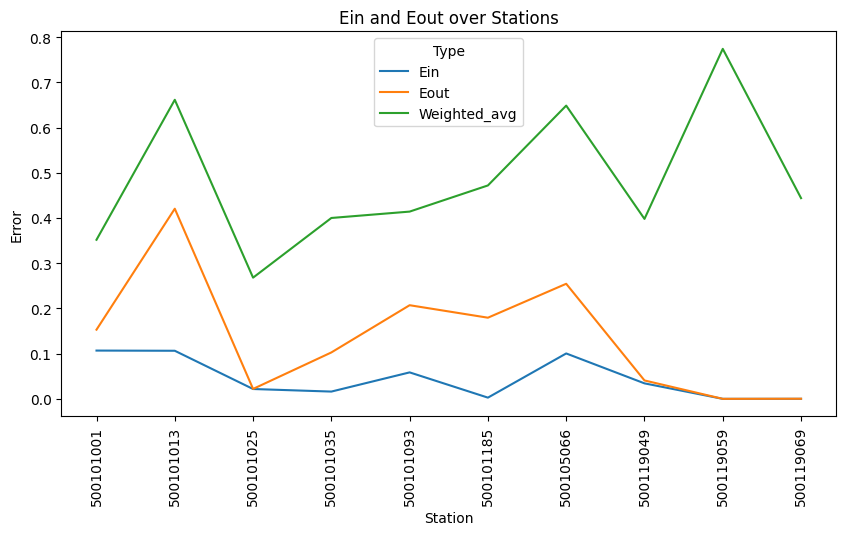

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

weighted_avg = [0.35179836349246596, 0.6613344905304286, 0.26802617236248344, 0.39999493795100904, 0.41409546484023935, 0.47193500865693716, 0.6484855662356462, 0.3979207783185336, 0.774010054888576, 0.4438668763348898]
# Create a DataFrame
df = pd.DataFrame({
    'Station': list(Ein.keys()),
    'Ein': list(Ein.values()),
    'Eout': list(Eout.values()),
    'Weighted_avg': weighted_avg
})

# Melt the DataFrame to have the values in a single column and an additional column for type
df_melt = df.melt(id_vars=['Station'], value_vars=['Ein', 'Eout', 'Weighted_avg'], var_name='Type', value_name='Error')

# Create the plot
plt.figure(figsize=(10, 5))
sns.lineplot(data=df_melt, x='Station', y='Error', hue='Type')

plt.title('Ein and Eout over Stations')
plt.xticks(rotation=90)  # Rotate x-axis labels for better visibility if they are long


# save to png
plt.savefig('EinEout.png', dpi=300, bbox_inches='tight')
plt.show()